In [4]:
#bring in relevant libraries
import pandas as pd
import json
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import numpy as np
import httplib, urllib
import re
import requests
import datetime
import time
from datetime import datetime, timedelta
import httplib, urllib, json, locale
from urlparse import urlparse

In [26]:



# Generating a payment report with the Square Connect API.


# Get this from your application dashboard (https://connect.squareup.com/apps)
# this is secret, don't share
access_token = ''

# Standard HTTP headers for every Connect API request
request_headers = {'Authorization': 'Bearer ' + access_token,
                   'Accept': 'application/json',
                   'Content-Type': 'application/json'}
  
# The base URL for every Connect API request
connection = httplib.HTTPSConnection('connect.squareup.com')
                   
# Uses the locale to format currency amounts correctly
locale.setlocale(locale.LC_ALL, 'en_US')

# Helper function to convert cent-based money amounts to dollars and cents
def format_money(amount):
  return locale.currency(amount / 100.)


# Obtains all of the business's location IDs. Each location has its own collection of payments.
def get_location_ids():
  request_path = '/v1/me/locations'
  connection.request('GET', request_path, '', request_headers)
  response = connection.getresponse()

  # Transform the JSON array of locations into a Python list
  locations = json.loads(response.read())

  location_ids = []
  for location in locations:
    location_ids.append(location['id'])

  return location_ids


# Downloads all of a business's payments
def get_payments(location_ids):

#get time right now, timezone should be correct if computer is synced properly
  d = datetime.utcnow()
  
    

#turn current time into a bunch of strings that we can add together to form link parameters below
  year,month,day,hour,minute,second = str(d.year),str(d.month),str(d.day),str(d.hour),str(d.minute),str(d.second)

#if any of our dates/times are only one digit, we add a '0' to the front to make them suitable for URL 
  if len(day) == 1:
        day = '0'+ day
  if len(month) == 1:
        month = '0'+ month
  if len(hour) == 1:
        hour = '0' + hour
  if len(minute) == 1:
        minute = '0' + minute
  if len(second) == 1:
        second = '0' + second
  parameters = urllib.urlencode({'begin_time': year + '-' + month + '-' + day + 'T16:00:00',
                                 'end_time'  : year + '-' + month + '-' + day + 'T' + hour + ':' + minute + ':' + second})
  payments = []

  # For each location...
  for location_id in location_ids:

    print 'Downloading payments for location with ID ' + location_id + '...'

    request_path = '/v1/' + location_id + '/payments?' + parameters
    more_results = True
    
    # ...as long as there are more payments to download from the location...
    while more_results:

      # ...send a GET request to /v1/LOCATION_ID/payments
      connection.request('GET', request_path, '', request_headers)
      response = connection.getresponse()

      # Read the response body JSON into the cumulative list of results
      payments = payments + json.loads(response.read())
      
      # Check whether pagination information is included in a response header, indicating more results
      pagination_header = response.getheader('link', '')
      if "rel='next'" not in pagination_header:
        more_results = False
      else:

        # Extract the next batch URL from the header.
        #
        # Pagination headers have the following format:
        # <https://connect.squareup.com/v1/LOCATION_ID/payments?batch_token=BATCH_TOKEN>;rel='next'
        # This line extracts the URL from the angle brackets surrounding it.
        next_batch_url = urlparse(pagination_header.split('<')[1].split('>')[0])

        request_path = next_batch_url.path + '?' + next_batch_url.query

  # Remove potential duplicate values from the list of payments
  seen_payment_ids = set()
  unique_payments = []

  for payment in payments:
    if payment['id'] in seen_payment_ids:
      continue
    seen_payment_ids.add(payment['id'])
    unique_payments.append(payment)

  return unique_payments


if __name__ == '__main__':

  # Get all 2015 payments from all of the business's locations
  payments = get_payments(get_location_ids())
  pay_data = payments
  # Print a sales summary report of the payments
  #print_sales_report(payments)

  connection.close()


In [27]:
#list items, list payments

# All requests to the Square Connect API require an access token in an
# Authorization header. Specify your application's personal access token here
# (available from https://connect.squareup.com/apps)
access_token = ''

# In addition to an Authorization header, requests to the Connect API should
# include the indicated Accept and Content-Type headers.
request_headers = {'Authorization': 'Bearer ' + access_token,
               'Accept':        'application/json',
               'Content-Type':  'application/json'}

# Send a GET request to the ListLocations endpoint and obtain the response.
connection = httplib.HTTPSConnection('connect.squareup.com')
request_path = '/v1//items'
connection.request('GET', request_path, '', request_headers)
response = connection.getresponse()



# Convert the returned JSON body into an array of locations you can work with.
items_data = json.loads(response.read())

# Pretty-print the locations array.
#locations = json.dumps(locations, indent=2, separators=(',',': '))

In [28]:

#making empty lists to fill with JSON pulled data
name_list = []
quant_list = []
quant_id_list = []
time_list = []
#pulling in item name,quantity purchased for the day, id of item, and time of purchase
for i in pay_data:
    for n in range(10):
        #all of our entries should be complete every time, if not, we'll add a nan
        try:
            name_list.append(i['itemizations'][n]['name'])
        except:
            name_list.append(np.nan)
        try:
            quant_list.append(i['itemizations'][n]['quantity'])
        except:
            quant_list.append(np.nan)
        try:
            quant_id_list.append(i['itemizations'][n]['item_detail']['item_id'])
        except:
            quant_id_list.append(np.nan)
        try:
            time_list.append(i['created_at'])
        except:
            time_list.append(np.nan)

        
        
id_list = []
url_list = []
names_list = []
price_list = []
#pulling in item, id, price of item, and image url
for m in items_data:
    #try and pull in data, if it doesn't exist for the instance, add a nan to be handled later
    try:      
        names_list.append(m['name'])
    except:
        names_list.append(np.nan)
    try:
        id_list.append(m['id'])
    except:
        id_list.append(np.nan)
    try:
        url_list.append(m['master_image']['url'])
    except:
        url_list.append(np.nan)
    try:
        price_list.append(m['variations'][0]['price_money']['amount'])
    except:
        price_list.append(np.nan)
        



In [29]:
#create data frame for each item on the menu and all the relevant information about it
df2 = pd.DataFrame({'id':id_list,'url':url_list, 'name':names_list, 'price':price_list})
df2.price = df2.price/100

In [30]:
#the items without a url are not typical menu items, so we get rid of those entries.
df2 = df2.dropna(subset = ['name']).reset_index()


In [31]:
#Compile the payment data into a dataframe
df = pd.DataFrame({'quantity':quant_list,'id':quant_id_list,'item_name':name_list,'time_of_sale':time_list})


In [32]:
#mergethe dataframes on ID, but maintain
fin_df = df.merge(df2, on = 'id', how = 'outer')

In [33]:
#we aren't interest in all of the columns from the original two dataframe, so we take the ones we want
fin_df = fin_df[['name','quantity','id','price','url','time_of_sale']]

In [34]:
#we are turning quantity into a numeric so we can aggregate it to get totala quantity sold in our group by below
fin_df.quantity = pd.to_numeric(fin_df.loc[:,'quantity'])
fin_df = fin_df[fin_df.name.str.contains("drink") == False]
fin_df = fin_df[fin_df.name.str.contains("Drink") == False]

In [35]:
#groupby quantity to get total sold for each product
fin_df = fin_df.groupby(['name','id','price','url']).sum().reset_index().sort_values('quantity', ascending = False)

In [36]:
fin_df = fin_df.reset_index(drop=True)

In [37]:
#get name and quantity to faciliate plotting
x = fin_df.name
y = fin_df.quantity

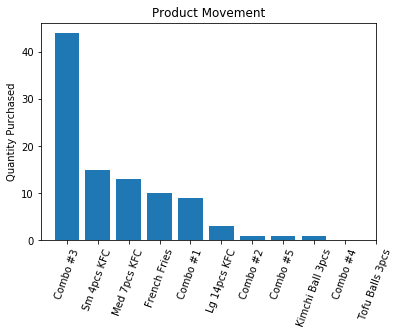

In [38]:
#bar plots want a list of integers for their x-values
x_r = range(len(x))


plt.bar(x_r,y, align='center')

#bring in the labels (names) and rotate the labels to make them easy to read
plt.xticks(x_r,x, rotation = 70)
plt.title('Product Movement')
plt.ylabel('Quantity Purchased')


plt.show()

In [39]:
print('Hot Products:\n{}\n{}\n{}' .format(x[0],x[1],x[2]))

Hot Products:
Combo #3
Sm 4pcs KFC
Med 7pcs KFC


In [40]:
print('Slow Products:\n{}' .format(x[-3:]))

Slow Products:
8     Kimchi Ball 3pcs
9             Combo #4
10     Tofu Balls 3pcs
Name: name, dtype: object


In [41]:
df['time_of_sale'] = pd.to_datetime(df['time_of_sale']) - timedelta(hours = 7)

#function to determine whether the sale was around breakfast, lunch, or dinner/evening
def t_o_d(time):
    if time.hour < 12 and time.hour >= 5:
        return 'Breakfast'
    if time.hour >= 11 and time.hour < 17:
         return 'Lunch'
    if time.hour >= 17 or time.hour < 5:
         return 'Dinner'
        
#function to determine whether the sale was on a weekend or weekday        
def week_weekend (time):
    if time.weekday() != 'saturday' and time.weekday() != 'sunday':
        return 'weekday'
    else:
        return 'weekend'

In [42]:
#if quantity is NaN then we know its a worthless entry, so we drop it
df = df.dropna(subset=['quantity'])

In [43]:
#apply our time of day function to our time of sale function
df['time_of_day'] = df.time_of_sale.apply(t_o_d)

In [44]:
#apply the weekday/weekend function
df['week_weekend'] = df.time_of_sale.apply(week_weekend)

In [45]:
df

,id,item_name,quantity,time_of_sale,time_of_day,week_weekend
0,a2ec19f9-aac9-4092-92cb-94f9cb545683,Combo #1,1.00000000,2017-08-03 11:40:09,Breakfast,weekday
1,cffef541-1b34-4e6d-b3c5-ac39d70f2478,Pr. Drink,1.00000000,2017-08-03 11:40:09,Breakfast,weekday
2,7123558c-9caa-4667-bdde-dfb114658548,French Fries,1.00000000,2017-08-03 11:40:09,Breakfast,weekday
10,a2ec19f9-aac9-4092-92cb-94f9cb545683,Combo #1,1.00000000,2017-08-03 12:01:33,Lunch,weekday
20,c7bdcc17-1fb4-40bc-9035-b9324a070f02,Sm 4pcs KFC,1.00000000,2017-08-03 12:02:51,Lunch,weekday
21,7123558c-9caa-4667-bdde-dfb114658548,French Fries,1.00000000,2017-08-03 12:02:51,Lunch,weekday
22,908e4b1c-5e43-43fd-88b4-923604ed96cb,Drink,1.00000000,2017-08-03 12:02:51,Lunch,weekday
30,545584bc-1d4b-403b-926d-e38174f78300,Combo #3,1.00000000,2017-08-03 12:05:23,Lunch,weekday
40,a2ec19f9-aac9-4092-92cb-94f9cb545683,Combo #1,1.00000000,2017-08-03 12:10:56,Lunch,weekday
50,66bb7f7c-6bab-4439-9b4a-ec3c0029967f,Combo #5,1.00000000,2017-08-03 12:11:37,Lunch,weekday
